In [1]:
# import pandas to read in CSV files
import pandas as pd

# import matplotlib + seaborn for exploratory data analysis
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# import random, datetime, pickle for creation of non-accident data
import random
from datetime import datetime, timedelta
import pickle

# import sklearn.metrics for analysis
from sklearn.metrics import mean_squared_error

# imports for model
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, recall_score

# imports for API
import json

In [2]:
# read in accident data CSVs for 2015 - 2017
acc15 = pd.read_csv('/Users/ianforrest/Desktop/coding/repos/DS_Safe-Routes/modeling/accident15.csv')
acc16 = pd.read_csv('/Users/ianforrest/Desktop/coding/repos/DS_Safe-Routes/modeling/accident16.csv')
acc17 = pd.read_csv('/Users/ianforrest/Desktop/coding/repos/DS_Safe-Routes/modeling/accident17.csv')

In [3]:
# check shape of acc csvs from 2015 - 2017
acc15.shape, acc16.shape, acc17.shape

((32538, 52), (34748, 52), (34247, 52))

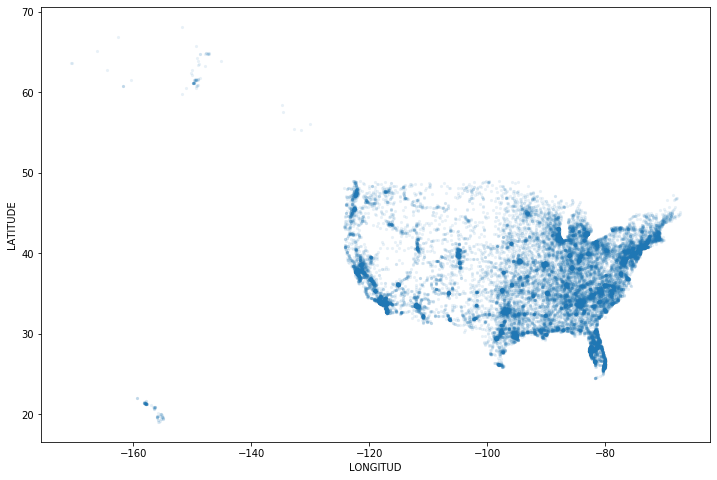

In [4]:
# initial data visualization
# longitude less than 600 to eliminate unknown values (999), unavailable values (888),
# and unreported values (777)
df = acc17[acc17['LONGITUD']<600]
plt.figure(figsize=(12, 8))
sns.scatterplot('LONGITUD', 'LATITUDE', data=df,
                alpha=0.1, linewidth=0, s=10
               );

In [5]:
# initial check of columns in dataframes
acc17.columns

Index(['STATE', 'ST_CASE', 'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PEDS',
       'PERNOTMVIT', 'PERMVIT', 'PERSONS', 'COUNTY', 'CITY', 'DAY', 'MONTH',
       'YEAR', 'DAY_WEEK', 'HOUR', 'MINUTE', 'NHS', 'RUR_URB', 'FUNC_SYS',
       'RD_OWNER', 'ROUTE', 'TWAY_ID', 'TWAY_ID2', 'MILEPT', 'LATITUDE',
       'LONGITUD', 'SP_JUR', 'HARM_EV', 'MAN_COLL', 'RELJCT1', 'RELJCT2',
       'TYP_INT', 'WRK_ZONE', 'REL_ROAD', 'LGT_COND', 'WEATHER1', 'WEATHER2',
       'WEATHER', 'SCH_BUS', 'RAIL', 'NOT_HOUR', 'NOT_MIN', 'ARR_HOUR',
       'ARR_MIN', 'HOSP_HR', 'HOSP_MN', 'CF1', 'CF2', 'CF3', 'FATALS',
       'DRUNK_DR'],
      dtype='object')

In [6]:
# create list of feature columns
# details found in 'notes.txt' file
columns = ['YEAR', 'MONTH', 'DAY', 'DAY_WEEK',
           'HOUR', 'LATITUDE', 'LONGITUD', 
           'PERMVIT', 'ROUTE', 'TYP_INT', 
           'MAN_COLL', 'RELJCT1', 'RELJCT2', 
           'LGT_COND', 'WEATHER']

In [7]:
# apply column filter to acc15, acc16, acc17
acc15 = acc15[columns]
acc16 = acc16[columns]
acc17 = acc17[columns]

In [8]:
# add 'ACCIDENT' column to acc dataframes with value 1
# represents classification of 'ACCIDENT' for model
acc15['ACCIDENT'] = 1
acc16['ACCIDENT'] = 1
acc17['ACCIDENT'] = 1

In [9]:
# remove unknown (999), not avaliable (888), not provided (777)
# latitude and longitude values from dataframes
acc15 = acc15.loc[(acc15['LATITUDE'] <= 600) & (acc15['LONGITUD'] <= 600)]
acc16 = acc16.loc[(acc15['LATITUDE'] <= 600) & (acc16['LONGITUD'] <= 600)]
acc17 = acc17.loc[(acc15['LATITUDE'] <= 600) & (acc17['LONGITUD'] <= 600)]

In [10]:
# combine acc15, acc16, acc17 into one dataframe
acc = acc15.append(acc16, sort=False, ignore_index = True)
acc = acc.append(acc17, sort=False, ignore_index = True)

In [11]:
acc['YEAR'].value_counts()

2015    32396
2016    32269
2017    32166
Name: YEAR, dtype: int64

In [12]:
# create function to generate random datetime for a given year
# generates year, month, day, hour, minute, and second data for datetime object
# used for non-accident classification data

def random_date(min_year=1900, max_year=datetime.now().year):
    start = datetime(min_year, 1, 1, 0, 0, 0)
    years = max_year - min_year + 1
    end = start + timedelta(days=365 * years)
    return start + (end - start) * random.random()

In [13]:
random_date(2015,2017)

datetime.datetime(2017, 10, 7, 6, 27, 36, 441840)

In [14]:
# create function to create random rows in dataframe based on acc data
# incorporates random_date function created earlier
def create_random_row(row):
    new_row = pickle.loads(pickle.dumps(row))
    for _ in range(1000):
        new_datetime = random_date(2015, 2017)
        condition = (
            (acc['DAY']==new_datetime.day) &
            (acc['MONTH']==new_datetime.month) &
            (acc['YEAR']==new_datetime.year) &
            (acc['HOUR']==new_datetime.hour)
        )
        if acc[condition].empty:
            continue
        else:
            break
    new_row['DAY'] = new_datetime.day
    new_row['MONTH'] = new_datetime.month
    new_row['YEAR'] = new_datetime.year
    new_row['DAY_WEEK'] = new_datetime.weekday()
    new_row['HOUR'] = new_datetime.hour
    distance = random.uniform(-0.000009, 0.000009)
    new_row['LATITUDE'] = row['LATITUDE'] + distance
    distance = random.uniform(-0.000009, 0.000009)
    new_row['LONGITUD'] = row['LONGITUD'] + distance
    new_row['ACCIDENT'] = 0
    return new_row.values

In [15]:
# create dataframe for non-accident data
noacc = []    
for rid, row in acc.iterrows():
    new_row = create_random_row(row)
    new_row2 = create_random_row(row)
    new_row3 = create_random_row(row)
    new_row4 = create_random_row(row)
    new_row5 = create_random_row(row)
    for _ in range(1):
        noacc.append(new_row)
        noacc.append(new_row2)
        noacc.append(new_row3)
        noacc.append(new_row4)
        noacc.append(new_row5)
noacc = pd.DataFrame(noacc, columns=acc.columns)

In [16]:
# check size of noacc data
noacc.shape

(484155, 16)

In [17]:
noacc['YEAR'].value_counts()

2015.0    162186
2016.0    161523
2017.0    160446
Name: YEAR, dtype: int64

In [18]:
# merge acc and nonacc dataframes into all_acc dataframe
all_acc = acc.append(noacc, sort=False, ignore_index=True)

In [19]:
all_acc['YEAR'].value_counts()

2015.0    194582
2016.0    193792
2017.0    192612
Name: YEAR, dtype: int64

In [20]:
# check boolean values, all_acc dataframe shape 
print('ACCIDENT column values:', '\n',all_acc['ACCIDENT'].value_counts(), '\n', '\n', 'Dataframe shape:', all_acc.shape)

ACCIDENT column values: 
 0.0    484155
1.0     96831
Name: ACCIDENT, dtype: int64 
 
 Dataframe shape: (580986, 16)


In [21]:
# check mean baseline, mse baseline
print('Mean Baseline:', all_acc['ACCIDENT'].mean())
print('MSE Baseline:', mean_squared_error(all_acc['ACCIDENT'],
                                         [all_acc['ACCIDENT'].mean()]* len(all_acc)))

Mean Baseline: 0.16666666666666666
MSE Baseline: 0.13888888888888953


In [22]:
# Train/Test Split
# Train model using years 2015 & 2016
# Test model using year 2017

X = all_acc.copy()

X_train = X.loc[all_acc['YEAR'] < 2017]
X_test = X.loc[all_acc['YEAR'] >= 2017]
y_train = X_train['ACCIDENT']
y_test = X_test['ACCIDENT']

X_train = X_train.drop(['ACCIDENT'], axis=1)
X_test = X_test.drop(['ACCIDENT'], axis=1)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((388374, 15), (192612, 15), (388374,), (192612,))

In [24]:
# XGBRegressor Model Fit
# ce.OrdinalEncoder for all features
# SimpleImputer for all missing values
# Fit pipeline to training data

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    XGBRegressor(n_estimators=100,random_state=30,n_jobs=-1)
)

pipeline.fit(X_train, y_train);

/Users/ianforrest/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/Users/ianforrest/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[17:21:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [25]:
# use pipeline to make prediction on X_test set
# check MSE of XGBRegressor model

y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
aps = average_precision_score(y_test, y_pred)
print('Test MSE score:', mse)
print('Test ROC AUC score:', roc)
print('Test Avg Precision score:', aps)

Test MSE score: 0.10615122063533342
Test ROC AUC score: 0.8167864369348499
Test Avg Precision score: 0.5248373749116612


In [26]:
# Get feature importances
xgbr = pipeline.named_steps['xgbregressor']
importances = pd.Series(xgbr.feature_importances_, X_train.columns)

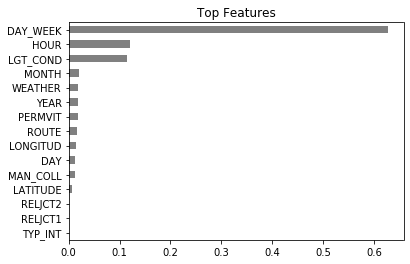

In [27]:
# Plot top features
plt.title('Top Features')
importances.sort_values().plot.barh(color='grey');

In [28]:
# pull sample of acc/nonacc events and check respective probabilities of classification
prediction = pipeline.predict(all_acc.drop('ACCIDENT', axis=1))
df_pred = pd.DataFrame([all_acc['ACCIDENT'], prediction]).T
df_pred.columns = ['ACCIDENT', 'PROBABILITY']
df_pred.sample(3)

,ACCIDENT,PROBABILITY
246862,0.0,0.201788
69022,1.0,0.219961
266315,0.0,0.236161


In [34]:
prediction = pipeline.predict(acc.drop('ACCIDENT', axis=1))
df_pred = pd.DataFrame([acc['LATITUDE'], acc['LONGITUD'], acc['YEAR'], prediction]).T
df_pred.columns = ['LATITUDE', 'LONGITUD', 'ACCIDENT YEAR','PREDICTION']
df_pred_25 = df_pred.sample(25)

In [37]:
fig = go.Figure(data=go.Scattergeo(
        lon = df_pred_25['LONGITUD'],
        lat = df_pred_25['LATITUDE'],
        text = df_pred_25['PREDICTION'],
        mode = 'markers',
        marker_color = df_pred_25['ACCIDENT YEAR'],
        ))

fig.update_layout(
        title = 'US Accidents: 2015 - 2017',
        geo_scope='usa',
    )
fig.show()